# YOLO Object Tracking Test 

This notebook explores the possiblity of making use of the YOLO algorithm to perform tracking of the mouse moving within a maze. 

YOLO is a machine learning model designed to perform real-time object localization and detection and is widely used for a variety of computer vision based tasks. It's well known for its impressive speed and accuracy, and ease of use. 

In this experiment, we use YOLO v8.2 to perform image localization. This is the process of identifying a set of two points on the image, known as the bounding box, which surround an object within the image. 

In [1]:
import numpy as np 
import cv2 
from tqdm import trange
import matplotlib.pyplot as plt 
import ultralytics 
from ultralytics import YOLO
import wandb
import torch

import os 
from typing import Tuple, Optional
import datetime 


VIDEO_PATH = "/Users/henrywilliams/Downloads/videos/maze_test.mp4" 
CREATE_DATASET = False
WANDB_SILENT = True
TRAIN = False 

if TRAIN: 
    from wandb.integration.ultralytics import add_wandb_callback 

    os.environ["WANDB_SILENT"] = "true"

    wandb.login()
    wandb.init(
        project="mice-maze",
        job_type="training",
        entity="lainon",
        name="yolov8 for mouse tracking",
        notes="Using larger dataset (n=595), with random rotation of images"
    )

yolo = YOLO()
cap = cv2.VideoCapture(VIDEO_PATH)
n_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)

print("VIDEO INFORMATION: ")
print("x\t\ty\t\tfps")
print(f"{cap.get(cv2.CAP_PROP_FRAME_WIDTH)}\t\t{cap.get(cv2.CAP_PROP_FRAME_HEIGHT)}\t\t{cap.get(cv2.CAP_PROP_FPS)}")
print(f"Video Duration:\t\t\t{datetime.timedelta(seconds=(cap.get(cv2.CAP_PROP_FRAME_COUNT) / cap.get(cv2.CAP_PROP_FPS)))}")

VIDEO INFORMATION:

x               y               fps

260.0           260.0           30.0

Video Duration:                 0:45:12.233333

# Create a Dataset

The following code cell takes 250 random frames from the video capture, and saves them to the `./frames/` directory. These frames are later annotated and used to fine-tune the YOLO model. To change where the frames are saved, modify the `OUTPUT_DIR` variable, and in order to change the number of samples captured, modify the `TOTAL_SAMPLES` variable. 

In [2]:
TOTAL_SAMPLES = 250
OUTPUT_DIR = './frames'

def get_nth_frame(cap: cv2.VideoCapture, n: int) -> np.ndarray: 
    """
    Retrieve the nth frame from a video capture object.

    This function extracts the nth frame from a given video capture object `cap`. 
    If `n_frames` is not provided, the function will determine the total number of frames 
    in the video. The frame counter is reset to its last value before the nth frame was 
    retrieved

    Parameters:
    cap (cv2.VideoCapture): The video capture object from which to extract the frame.
    n (int): The frame number to retrieve.

    Returns:
    np.ndarray: The nth frame as an array.

    Raises:
    IndexError: If `n` exceeds the total number of frames available in the video.
    RuntimeError: If the frame could not be read from the video capture object.

    Example usage:
    >>> cap = cv2.VideoCapture('video.mp4')
    >>> frame = get_nth_frame(cap, 10)
    >>> cv2.imshow('10th Frame', frame)
    >>> cv2.waitKey(0)
    >>> cv2.destroyAllWindows()
    """
    n_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT) 
    current_frame = cap.get(cv2.CAP_PROP_POS_FRAMES)

    if n > n_frames: 
        raise IndexError(f"Attempted to get {n}th frame when only {n_frames} frames exist")
    
    cap.set(cv2.CAP_PROP_POS_FRAMES, n)
    
    ret, frame = cap.read()
    
    cap.set(cv2.CAP_PROP_POS_FRAMES, current_frame)

    if not ret: 
        raise RuntimeError(f"Failed to read {n}th frame")
    
    return frame 


for i in trange(TOTAL_SAMPLES) if CREATE_DATASET else trange(0, desc="Already gathered frames"):
    n = np.random.randint(0, n_frames)
    frame = get_nth_frame(cap, n)
    cv2.imwrite(f"./frames/frame-{n}.jpg", frame)

Already gathered frames: 0it [00:00, ?it/s]


## Annotation 

Please visit [roboflow](https://universe.roboflow.com/mice-maze/mice-maze) to view and download the annotated dataset. Ensure the dataset is in the same format as the following. 

    mice-maze-dataset
    ├── data.yaml
    ├── images
    │   ├── test
    │   ├── train
    │   └── val
    └── labels
        ├── test
        ├── train
        └── val

You may also need to edit the `data.yaml` file in order to get the data set working correctly. Here is an example of such a file 

```yaml
path: /path/to/mice-maze-dataset
train: images/train  # Path to training images
val: images/val  # Path to validation images
test: images/test  # Path to test images

# Class names (you can add more if you have more classes)
names:
    0: mouse
```

## Fine-tuning the model

In [3]:
# Select the best backend to train the model on 
# If no such backend is available, such as a CUDA-enabled 
# GPU, found in modern Nvidia cards, or MPS found in 
# Apple devices with an Apple Silicon CPU (M1, M2, etc), 
# make use of the CPU 
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_built():
    # NOTE: See https://github.com/ultralytics/ultralytics/issues/12999
    device = torch.device('mps')
else: 
    print("No backend availale, defaulting to CPU")
    print("This might take a while, please ensure you installed the correct version of pytorch for your hardware")
    print("Please see `https://pytorch.org/get-started/locally/`")
    device = torch.device('cpu')

if TRAIN: 
    try: 
        yolo = ultralytics.YOLO('yolov8n.pt')
        add_wandb_callback(yolo, enable_model_checkpointing=True)
        yolo.train(data="Mice-Maze-2/data.yaml", device=device, epochs=100)
    finally:
        # Make sure to finish the run regardless of if it finishes successfully 
        # or not 
        wandb.finish()
else: 
    print("Model already trained, loading...")

Model already trained, loading...

# Real-World Performance of the Model 

Use the best performing model from training on the test video to find the path of the mouse takes through the maze. Save the array to file because it takes about 30ms to predict location which can take up to an hour for the full test video.

In [4]:
trained_yolo = ultralytics.YOLO("/Users/henrywilliams/Documents/programming/python/mice-maze-rewrite/yolo-test/runs/detect/train40/weights/best.pt")
path_name = "path_xywh_v1_full.npy"
if not os.path.exists(path_name):
    path = trained_yolo.track(VIDEO_PATH, persist=True)
    path_xywh = np.empty((len(path), 4))
    for i, result in enumerate(path):
        if result.names != {0: 'mouse'}:
            print("No mouse found in this frame")
            continue 

        if len(result.boxes.xywh) == 0:
            continue

        x, y, w, h = result.boxes.xywh.tolist()[0]
        path_xywh[i] = np.array([x, y, w, h])
    np.save(path_name, path_xywh)
else: 
    path_xywh = np.load(path_name)

In [5]:
def transform_bbox(x: float, y: float, w: float, h: float) -> Tuple[float, float]:
    x_midpoint = x + (w / 2)
    y_midpoint = y + (h / 2)
    
    # return (x_midpoint, y_midpoint)
    return x, y


path_xy = np.apply_along_axis(lambda bbox: transform_bbox(*bbox), axis=1, arr=path_xywh)

# Data Postprocessing 

Upon extracting the locations of the mice within the maze, we see that there are a few anomolous data points which need to be removed from the dataset. The following cells will demonstrate how invalid elements are detected and removed. 

In [21]:
bg_image = cv2.cvtColor(get_nth_frame(cap, 30), cv2.COLOR_BGR2RGB)

def plot_data(path: np.ndarray, ax, title: Optional[str] = None, **kwargs):
    w, h, _ = bg_image.shape
    xs = path[:, 0]
    ys = path[:, 1]

    heatmap, _, _ = np.histogram2d(
        xs, ys,
        bins=(w, h),
        range=[[0, w], [0, h]]
    )

    heatmap = np.log1p(heatmap.T)
    heatmap /= heatmap.max()

    alpha_mask = np.zeros_like(heatmap)
    alpha_mask[heatmap > 0] = 1

    if title is not None:
        ax.set_title(title)

    ax.imshow(bg_image, extent=[0, w, 0, h])
    ax.imshow(heatmap, alpha=alpha_mask, vmin=0, vmax=1, zorder=2, interpolation="nearest", **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

    ax.set_xlim(0, w)
    ax.set_ylim(0, h)
    ax.invert_yaxis()

## Values out of expected range

As the image of the mouse has a resolution of only 260x260, any values outside of the range 0 < n < 260 can be removed. Furthermore, any elements which contain missing values such as NaN are also removed.  

Removed 38.96% of elements

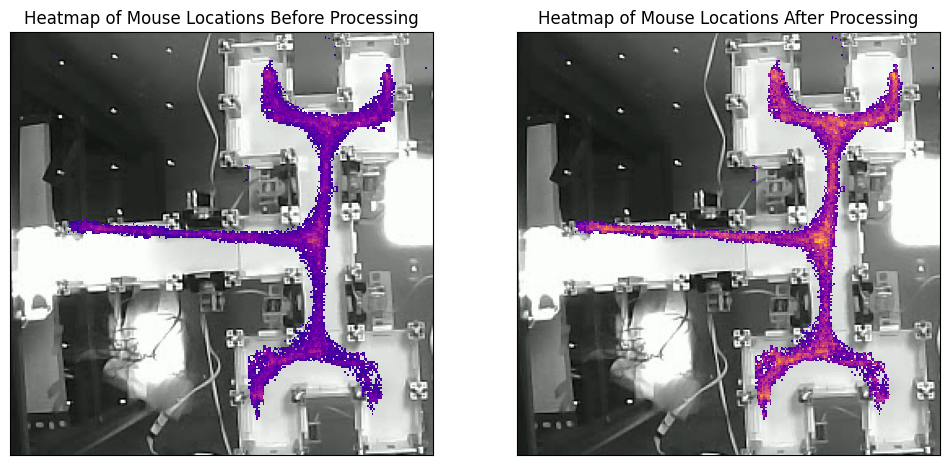

In [22]:
%matplotlib inline

MIN_THRESHOLD = 0
MAX_THRESHOLD = 260

def postprocess_data(path: np.ndarray, min: int, max: int, display_stats: bool = False, remove_nans: bool = True) -> np.ndarray: 
    pre_filtering_length = len(path)

    mask_x = [not (min < x < max) for x in path[:, 0]]
    mask_y = [not (min < y < max) for y in path[:, 1]]

    nan_mask = np.isnan(path_xy).any(axis=1)

    combined_xy_thresh = np.logical_or(mask_x, mask_y)
    combined_mask = np.logical_or(combined_xy_thresh, nan_mask)

    filtered_path = path[~combined_mask if remove_nans else ~combined_xy_thresh]

    post_filtering_length = len(filtered_path)
    percentage_lost = ((pre_filtering_length - post_filtering_length) / pre_filtering_length) * 100

    if display_stats:
        print(f"Removed {percentage_lost:.2f}% of elements")

    return filtered_path

post_proc_path = postprocess_data(path_xy, MIN_THRESHOLD, MAX_THRESHOLD, display_stats=True, remove_nans=True)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

plot_data(path_xy, axs[0], cmap="plasma", title="Heatmap of Mouse Locations Before Processing")

plot_data(post_proc_path, axs[1], cmap="plasma", title="Heatmap of Mouse Locations After Processing")
plt.show()

# Calibration

The images above show that while the distribution of points looks correct, roughly following the pattern of the maze, the locations do not align correctly with the maze shown in the image. To remedy this, a transformation matrix is used. 

The following code cell produces a simple tkinter GUI, which displays the raw distribution of points, and another which has been transformed according to a transformation matrix based on the parameters `tx` and `ty`, which offset the points in the x and y axis respectively, `angle` representing the rotation of the points, and `scale`, representing how much to scale the points by. 

Use the sliders in the GUI to transform the points until the heatmap looks correct, then press the Done button. The window may not close, simply alt-tab back to the window running this notebook to continue. 

Final values: TX=-9.26, TY=20.35, Angle=-5.16, Scale=1.00

[[    0.99595    0.089902     -9.2647]
 [  -0.089902     0.99595      20.346]
 [          0           0           1]]

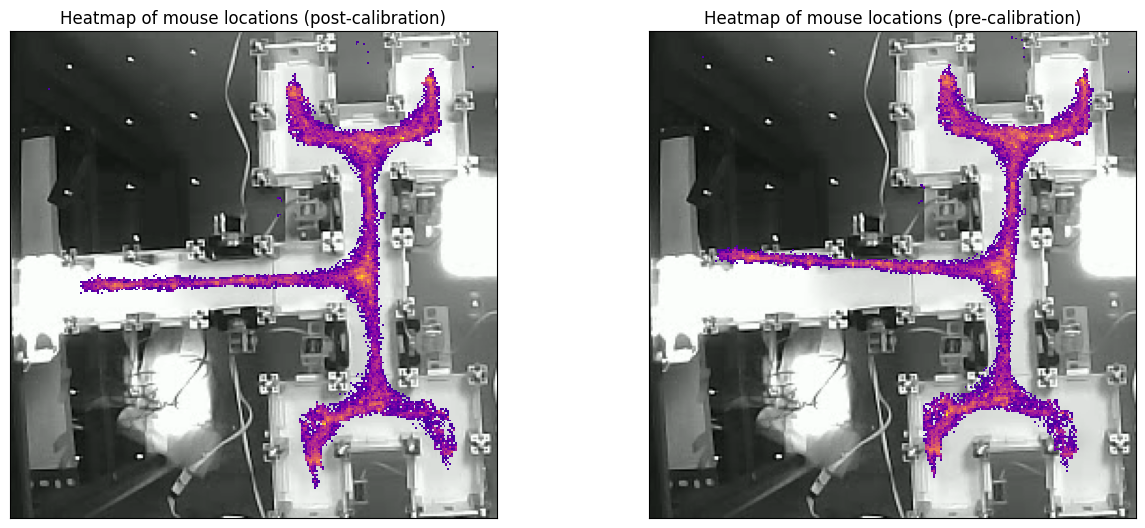

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import tkinter as tk
from tkinter import ttk

def invert_transformation_matrix(M: np.ndarray) -> Tuple[float, float, float, float]:
    """
    Extracts the translation, rotation, and scale components from a 3x3 transformation matrix.

    This function takes a 3x3 transformation matrix representing a 2D affine transformation in homogeneous coordinates
    and extracts the translation, rotation, and scale values. The matrix is assumed to contain these components applied
    in the order: scaling, rotation, and then translation.

    Parameters:
    M : np.ndarray
        A 3x3 NumPy array representing the transformation matrix.

    Returns:
    Tuple[float, float, float, float]
        A tuple containing the following extracted transformation variables:
        - tx (float): Translation component in the x direction.
        - ty (float): Translation component in the y direction.
        - rotation (float): Rotation angle in degrees. Positive values represent counter-clockwise rotation.
        - scale (float): Scaling factor.

    Raises:
    RuntimeError
        If the input matrix is not a 3x3 matrix.

    Example:
    >>> M = np.array([
    ...     [1.06066017, -1.06066017, 2.],
    ...     [1.06066017,  1.06066017, 3.],
    ...     [0., 0., 1.]
    ... ])
    >>> invert_transformation_matrix(M)
    (2.0, 3.0, 45.0, 1.5)
    """
    if not M.shape == (3, 3):
        raise RuntimeError("Cannot extract transformation variables from this matrix!")

    scale = np.sqrt(M[0, 0] ** 2 + M[0, 1] ** 2)
    
    rotation = np.degrees(np.arctan2(M[1, 0], M[0, 0]))
    
    tx = M[0, 2]
    ty = M[1, 2]

    return tx, ty, rotation, scale
    

def transformation_matrix(tx: float, ty: float, rotation: float, scale: float) -> np.ndarray:
    """
    Generates a 3x3 transformation matrix for 2D transformations including scaling, rotation, and translation.

    The transformation matrix is composed of the following transformations applied in this order:
    1. Scaling
    2. Rotation
    3. Translation

    Parameters:
    tx : float
        The translation component in the x direction.
    ty : float
        The translation component in the y direction.
    rotation : float
        The rotation angle in degrees. Positive values represent counter-clockwise rotation.
    scale : float
        The scaling factor. A value greater than 1 enlarges the object, while a value between 0 and 1 reduces it.

    Returns:
    np.ndarray
        A 3x3 NumPy array representing the combined transformation matrix in homogeneous coordinates.

    Example:
    >>> transformation_matrix(2, 3, 45, 1.5)
    array([[ 1.06066017, -1.06066017,  2.        ],
           [ 1.06066017,  1.06066017,  3.        ],
           [ 0.        ,  0.        ,  1.        ]])
    """
    theta = np.radians(rotation)
    
    S = np.array([
        [scale, 0, 0],
        [0, scale, 0],
        [0, 0, 1]
    ])
    
    R = np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ])
    
    T = np.array([
        [1, 0, tx],
        [0, 1, ty],
        [0, 0, 1]
    ])
    
    return T @ R @ S

def apply_transform(path: np.ndarray, tx: float, ty: float, angle: float, scale: float) -> np.ndarray:
    """
    Applies a transformation to a 2D path, including translation, rotation, and scaling.

    This function takes a set of 2D points and transforms them according to the specified translation, rotation, and scale.
    The transformation matrix is generated using these parameters and then applied to the input path.

    Parameters:
    path : np.ndarray
        A NumPy array of shape (N, 2), where N is the number of points. Each row represents a 2D point [x, y].
    tx : float
        The translation component in the x direction.
    ty : float
        The translation component in the y direction.
    angle : float
        The rotation angle in degrees. Positive values represent counter-clockwise rotation.
    scale : float
        The scaling factor. A value greater than 1 enlarges the object, while a value between 0 and 1 reduces it.

    Returns:
    np.ndarray
        A NumPy array of shape (N, 2), containing the transformed 2D points after applying the transformation.

    Example:
    >>> path = np.array([[1, 2], [3, 4], [5, 6]])
    >>> apply_transform(path, 2, 3, 45, 1.5)
    array([[ 2.12132034,  6.79289322],
           [ 4.94974747, 10.62132034],
           [ 7.77817459, 14.44974747]])
    """
    M = transformation_matrix(tx, ty, angle, scale)
    
    ones = np.ones((path.shape[0], 1))
    path_homogeneous = np.hstack([path, ones])
    transformed_path = (M @ path_homogeneous.T).T
    
    return transformed_path[:, :2]

def update_plot():
    """
    Update the plots on the GUI
    """
    tx = float(tx_var.get())
    ty = float(ty_var.get())
    angle = float(angle_var.get())
    scale = float(scale_var.get())
    
    transformed_path = apply_transform(post_proc_path, tx, ty, angle, scale)
    
    ax1.clear()
    ax2.clear()
    plot_data(transformed_path, ax1, title='Heatmap of mouse locations (post-calibration)', cmap='plasma')
    plot_data(post_proc_path, ax2, title='Heatmap of mouse locations (pre-calibration)', cmap='plasma')
    
    canvas.draw()

    tx_label.config(text=f"{tx:.2f}")
    ty_label.config(text=f"{ty:.2f}")
    angle_label.config(text=f"{angle:.2f}")
    scale_label.config(text=f"{scale:.2f}")

def on_done():
    """
    Handle quitting the GUI
    """
    root.quit()  
    root.destroy()

# Create the main window
root = tk.Tk()
root.title("Path Transformation")

# Create the figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2, 4))
canvas = FigureCanvasTkAgg(fig, master=root)
canvas_widget = canvas.get_tk_widget()
canvas_widget.pack(side=tk.TOP, fill=tk.BOTH, expand=1)

# Create a frame for sliders
slider_frame = ttk.Frame(root)
slider_frame.pack(side=tk.BOTTOM, fill=tk.X, padx=10, pady=10)

# Create sliders
if not os.path.exists("transformation_matrix.npy"):
    tx_var = tk.DoubleVar(value=0)
    ty_var = tk.DoubleVar(value=0)
    angle_var = tk.DoubleVar(value=0)
    scale_var = tk.DoubleVar(value=1)
else: 
    tx, ty, theta, k = invert_transformation_matrix(np.load("transformation_matrix.npy"))
    tx_var = tk.DoubleVar(value=tx)
    ty_var = tk.DoubleVar(value=ty)
    angle_var = tk.DoubleVar(value=theta)
    scale_var = tk.DoubleVar(value=k)


sliders = [
    ("Transform X", tx_var, -50, 50),
    ("Transform Y", ty_var, -50, 50),
    ("Angle", angle_var, -180, 180),
    ("Scale", scale_var, 0.5, 1.5)
]

value_labels = []

for i, (label, var, from_, to) in enumerate(sliders):
    ttk.Label(slider_frame, text=label).grid(row=i, column=0, sticky="e", padx=5, pady=5)
    slider = ttk.Scale(slider_frame, from_=from_, to=to, variable=var, command=update_plot)
    slider.grid(row=i, column=1, sticky="ew", padx=5, pady=5)
    value_label = ttk.Label(slider_frame, text=f"{var.get():.2f}")
    value_label.grid(row=i, column=2, sticky="w", padx=5, pady=5)
    value_labels.append(value_label)

slider_frame.columnconfigure(1, weight=1)

tx_label, ty_label, angle_label, scale_label = value_labels

done_button = ttk.Button(slider_frame, text="Done", command=on_done)
done_button.grid(row=len(sliders), column=1, pady=10)

# Initial plot
update_plot()

# Start the GUI event loop
root.mainloop()

# After the window is closed, print the final values
print(f"Final values: TX={tx_var.get():.2f}, TY={ty_var.get():.2f}, Angle={angle_var.get():.2f}, Scale={scale_var.get():.2f}")
M = transformation_matrix(tx_var.get(), ty_var.get(), angle_var.get(), scale_var.get())
np.save("transformation_matrix.npy", M)
print(M)